# Load Packages

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
# LightGBM is a gradient boosting framework that uses tree based learning algorithms
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    true_positive_rate, false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Helper Functions

In [2]:
def split(sensitive_feature, str_sensitive_feature):
    # Train-test split
    df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    d.drop(columns=['race', 'action_taken', 'ethnicity', 'gender', 'age']), 
    Y, 
    sensitive_feature, 
    str_sensitive_feature,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)
    return df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test


def get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test):
    global unmitigated_model, test_scores, test_preds
    # unmitigated_model = test_scores = test_preds = None
    lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
    }
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(df_train, Y_train)
    print(model)
    unmitigated_model = model
    # Scores on test set
    test_scores = model.predict_proba(df_test)[:, 1]
    test_scores = test_scores
    print("Test Scores: ", test_scores)
    # Train AUC
    print( "AUC: ", roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1]))
    # Predictions (0 or 1) on test set
    test_preds = (test_scores >= np.mean(Y_train)) * 1
    # LightGBM feature importance 
    lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
    plt.show()
    # We next use Fairlearn's `MetricFrame` to examine the the two different kinds of errors (false positives and false negatives) on the test data.
    mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    Y_test, test_preds, sensitive_features=A_str_test)
    print(mf.by_group)
    # We calculate several performance and fairness metrics below:
    # Metrics
    models_dict = {"Unmitigated": (test_preds, test_scores)}
    print()
    print(get_metrics_df(models_dict, Y_test, A_str_test))
    
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        # defined by team6 - equal opportunity - the percentage of people that have rightfully benefitted from the loan model
        "True positive rate": (
            lambda x: true_positive_rate(y_true, x), True),
        # defined by team6 - equalized odds - the percentage of people that have wrongfully benefitted from the loan model
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        # defined by UCI Ex - 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.)
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def get_thresholdOptimizer_model(model, test_preds_, test_scores_, A_train, A_test, A_str_test):
    # global TO, postprocess_est, postprocess_preds, df_train_balanced, Y_train_balanced, A_train_balanced, test_scores, test_preds, models_dict
    global TO, postprocess_est, postprocess_preds, test_scores, test_preds, models_dict

    # TO = postprocess_est = postprocess_preds = df_train_balanced = Y_train_balanced = A_train_balanced= test_scores = test_preds = None

    test_scores_ = test_scores
    test_preds_ = test_preds
    postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)
    # Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
    # as there are points in the minority class (Y=1)
    balanced_idx1 = df_train[Y_train==1].index
    pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234, replace=True).index)
    df_train_balanced = df_train.loc[pp_train_idx, :]
    Y_train_balanced = Y_train.loc[pp_train_idx]
    A_train_balanced = A_train.loc[pp_train_idx]
    # save the parameters
    postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)
    TO = postprocess_est
    postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)
    
    postprocess_preds = postprocess_preds
    models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
    models_dict = models_dict
    print(get_metrics_df(models_dict, Y_test, A_str_test))
    return df_train_balanced, Y_train_balanced, A_train_balanced
    
def get_gridSearch_model(model, postprocess_preds, test_scores, test_preds, models_dict, A_str_test, df_train_balanced, Y_train_balanced, A_train_balanced):
    global GS_models, GS_metrics
    # GS_models = GS_metrics = None
    # Train GridSearch
    sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=1000,
                   grid_limit=10)

    sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)
    sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
    sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_]
    equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
    ]
    balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
    auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]
    # Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
    all_results = pd.DataFrame(
        {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
    ) 
    non_dominated = []
    models = []
    for row in all_results.itertuples(): 
        accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
        if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
            models.append(row)
            non_dominated.append(True)
        else:
            non_dominated.append(False)
    GS_models = models
    equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
    balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
    auc_non_dominated = np.asarray(auc_sweep)[non_dominated]
    # Plot equalized odds difference vs balanced accuracy
    plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
    plt.scatter(balanced_accuracy_score(Y_test, test_preds),
                equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
                label="Unmitigated Model")
    plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
                equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
                label="ThresholdOptimizer Model")
    plt.xlabel("Balanced Accuracy")
    plt.ylabel("Equalized Odds Difference")
    plt.legend(bbox_to_anchor=(1.55, 1))
    plt.show()
    # As intended, GridSearch models appear along the trade-off curve between the large balanced accuracy (but also large disparity), and low disparity (but worse balanced accuracy). This gives the data scientist a flexibility to select a model that fits the application context best.
    # Plot equalized odds difference vs AUC
    plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
    plt.scatter(roc_auc_score(Y_test, test_scores),
                equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
                label="Unmitigated Model")
    plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
                equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
                label="ThresholdOptimizer Model")
    plt.xlabel("AUC")
    plt.ylabel("Equalized Odds Difference")
    plt.legend(bbox_to_anchor=(1.55, 1))
    plt.show()
    # Similarly, GridSearch models appear along the trade-off curve between AUC and equalized odds difference.
    # Compare GridSearch models with low values of equalized odds difference with the previously constructed models
    grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                        for i in range(len(sweep_preds))
                        if non_dominated[i] and equalized_odds_sweep[i]<0.1}
    models_dict.update(grid_search_dict)
    GS_metrics = models_dict
    print(get_metrics_df(models_dict, Y_test, A_str_test))


# Race - IL

In [3]:
# load the clean data
d = 'data/Fairlearn_IL_Chicago.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,0,1,0,1,3,2,2,3,2,2,1
1,0,1,1,0,0,1,2,2,2,4,3,4,1
2,0,1,1,1,0,1,1,2,2,3,2,1,1
3,0,1,0,1,0,1,3,2,2,2,2,2,1
4,1,1,1,1,0,1,3,2,2,4,2,3,1


In [4]:
# Extract the sensitive feature - example: race
A = d["race"].apply(lambda x:1 if x == 1 else 0)
A_str = A.map({ 1:"White", 0:"Non-White"})
A_str

0             White
1             White
2             White
3             White
4             White
            ...    
110877        White
110878        White
110879    Non-White
110880        White
110881        White
Name: race, Length: 110882, dtype: object

In [5]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110882 entries, 0 to 110881
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   ethnicity              110882 non-null  int64   
 1   race                   110882 non-null  int64   
 2   gender                 110882 non-null  int64   
 3   action_taken           110882 non-null  int64   
 4   preapproval_requested  110882 non-null  category
 5   loan_type              110882 non-null  category
 6   loan_purpose           110882 non-null  category
 7   interest_only_payment  110882 non-null  category
 8   balloon_payment        110882 non-null  category
 9   debt_to_income_ratio   110882 non-null  category
 10  age                    110882 non-null  int64   
 11  income                 110882 non-null  category
 12  loan_to_value_ratio    110882 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 5.8 MB


In [6]:
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = split(A, A_str)

In [7]:
len(df_test)

33265

In [8]:
len(Y_test)

33265

In [9]:
A_str_test

28941        White
71123        White
62952        White
9831     Non-White
24880        White
           ...    
82139        White
54506        White
69449        White
27144        White
6804         White
Name: race, Length: 33265, dtype: object

## Using a Fairness Unaware Model

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')
Test Scores:  [0.95130197 0.57020166 0.82919365 ... 0.91563331 0.87964674 0.91563331]
AUC:  0.8395135473436481


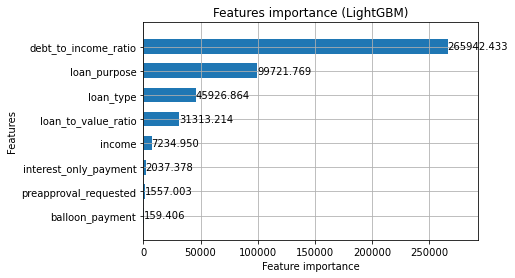

                FPR       FNR
race                         
Non-White  0.332436  0.104188
White      0.346758  0.115373

                               Unmitigated
Overall selection rate            0.763114
Demographic parity difference     0.057496
Demographic parity ratio          0.926051
------                                    
Overall balanced error rate       0.772642
Balanced error rate difference    0.012753
 ------                                   
True positive rate                0.887121
False positive rate difference    0.014322
False negative rate difference    0.011185
Equalized odds difference         0.014322
  ------                                  
Overall AUC                       0.843145
AUC difference                    0.005945


In [10]:
get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test)

In [11]:
unmitigated_IL_race = unmitigated_model
print(unmitigated_IL_race)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')


In [12]:
il_race_test_scores = unmitigated_IL_race.predict_proba(df_test)[:, 1]

In [13]:
il_race_test_preds = (il_race_test_scores >= np.mean(Y_train)) * 1

In [14]:
il_race_test_preds = pd.DataFrame(il_race_test_preds)

In [15]:
A_str_test.reset_index(drop= True, inplace= True)

In [16]:
unmigigated_pred_mid_race = pd.concat([il_race_test_preds , A_str_test], axis="columns")
unmigigated_pred_mid_race

,0,race
0,1,White
1,0,White
2,1,White
3,1,Non-White
4,1,White
...,...,...
33260,1,White
33261,1,White
33262,1,White
33263,1,White


In [17]:
unmigigated_pred_mid_race.to_excel(r'il_unmitigated_pred_race.xlsx', index=False)

## Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [18]:
df_train_balanced_race_IL, Y_train_balanced_race_IL, A_train_balanced_race_IL = get_thresholdOptimizer_model(unmitigated_IL_race, test_preds, test_scores, A_train, A_test, A_str_test)

                               Unmitigated ThresholdOptimizer
Overall selection rate            0.763114            0.88784
Demographic parity difference     0.057496           0.052185
Demographic parity ratio          0.926051           0.942075
------                                                       
Overall balanced error rate       0.772642            0.70981
Balanced error rate difference    0.012753           0.011998
 ------                                                      
True positive rate                0.887121           0.983268
False positive rate difference    0.014322           0.022227
False negative rate difference    0.011185           0.001768
Equalized odds difference         0.014322           0.022227
  ------                                                     
Overall AUC                       0.843145            0.70981
AUC difference                    0.005945           0.011998


In [19]:
ThresholdOptimizer_IL_race = TO
print(ThresholdOptimizer_IL_race)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'),
                   prefit=True)


The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


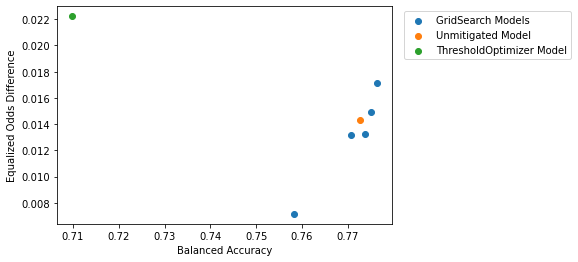

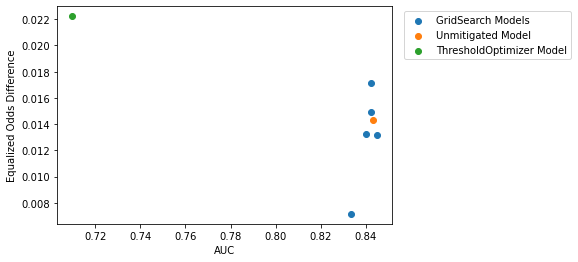

                               Unmitigated ThresholdOptimizer GridSearch_382  \
Overall selection rate            0.763114            0.88784       0.757944   
Demographic parity difference     0.057496           0.052185       0.064373   
Demographic parity ratio          0.926051           0.942075       0.916838   
------                                                                         
Overall balanced error rate       0.772642            0.70981        0.77631   
Balanced error rate difference    0.012753           0.011998        0.01047   
 ------                                                                        
True positive rate                0.887121           0.983268       0.883619   
False positive rate difference    0.014322           0.022227       0.017152   
False negative rate difference    0.011185           0.001768       0.003788   
Equalized odds difference         0.014322           0.022227       0.017152   
  ------                                

In [20]:
get_gridSearch_model(unmitigated_IL_race, postprocess_preds, test_scores, test_preds, models_dict, A_str_test, df_train_balanced_race_IL, Y_train_balanced_race_IL, A_train_balanced_race_IL)

In [21]:
GS_race_IL_models = GS_models
print(GS_race_IL_models)
print()
GS_race_IL_metrics = GS_metrics
print(GS_race_IL_metrics)

[Pandas(Index=382, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7763103299291998, disparity=0.01715249692522469), Pandas(Index=383, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7751464737514819, disparity=0.014955409752844928), Pandas(Index=384, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7737808770165697, disparity=0.013214986959419472), Pandas(Index=506, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7708304294043067, disparity=0.013199991960016755), Pandas(Index=666, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7583565776242731, disparity=0.007148

In [33]:
# chose the model with AUC = 85.98% from grid search
test_pred_gird_search_666 = GS_race_IL_metrics.get("GridSearch_666")[0]

In [34]:
test_pred_gird_search_666_series = pd.Series(test_pred_gird_search_666)
test_pred_gird_search_666_series.reset_index(drop=True, inplace=True)
A_str_test.reset_index(drop= True, inplace= True)

In [35]:
test_preds

array([1, 0, 1, ..., 1, 1, 1])

In [36]:
migigated_pred_mid_race = pd.concat([test_pred_gird_search_666_series , A_str_test], axis="columns")
migigated_pred_mid_race

,0,race
0,1,White
1,0,White
2,1,White
3,1,Non-White
4,1,White
...,...,...
33260,1,White
33261,1,White
33262,1,White
33263,1,White


In [37]:
migigated_pred_mid_race.to_excel(r'il_mitigated_pred_race.xlsx', index=False)

## Conclusion

In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.

# Age - IL

In [22]:
# load the clean data
d = 'data/Fairlearn_IL_Chicago.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,0,1,0,1,3,2,2,3,2,2,1
1,0,1,1,0,0,1,2,2,2,4,3,4,1
2,0,1,1,1,0,1,1,2,2,3,2,1,1
3,0,1,0,1,0,1,3,2,2,2,2,2,1
4,1,1,1,1,0,1,3,2,2,4,2,3,1


In [23]:
# Extract the sensitive feature - example: age - middle-aged vs non m-a
B = d["age"].apply(lambda x:1 if x == 2 else 0)
B_str = B.map({ 1:"Middle-Aged", 0:"Non-Middle-Aged"})
B_str

0             Middle-Aged
1         Non-Middle-Aged
2             Middle-Aged
3             Middle-Aged
4             Middle-Aged
               ...       
110877    Non-Middle-Aged
110878        Middle-Aged
110879    Non-Middle-Aged
110880        Middle-Aged
110881        Middle-Aged
Name: age, Length: 110882, dtype: object

In [24]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110882 entries, 0 to 110881
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   ethnicity              110882 non-null  int64   
 1   race                   110882 non-null  int64   
 2   gender                 110882 non-null  int64   
 3   action_taken           110882 non-null  int64   
 4   preapproval_requested  110882 non-null  category
 5   loan_type              110882 non-null  category
 6   loan_purpose           110882 non-null  category
 7   interest_only_payment  110882 non-null  category
 8   balloon_payment        110882 non-null  category
 9   debt_to_income_ratio   110882 non-null  category
 10  age                    110882 non-null  int64   
 11  income                 110882 non-null  category
 12  loan_to_value_ratio    110882 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 5.8 MB


In [25]:
df_train, df_test, Y_train, Y_test, B_train, B_test, B_str_train, B_str_test = split(B, B_str)

## Using a Fairness Unaware Model

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')
Test Scores:  [0.95130197 0.57020166 0.82919365 ... 0.91563331 0.87964674 0.91563331]
AUC:  0.8395135473436481


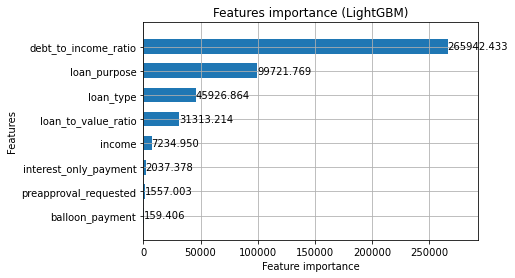

                      FPR       FNR
age                                
Middle-Aged      0.364986  0.114833
Non-Middle-Aged  0.321151  0.110893

                               Unmitigated
Overall selection rate            0.763114
Demographic parity difference      0.01927
Demographic parity ratio          0.975065
------                                    
Overall balanced error rate       0.772642
Balanced error rate difference    0.023887
 ------                                   
True positive rate                0.887121
False positive rate difference    0.043835
False negative rate difference    0.003939
Equalized odds difference         0.043835
  ------                                  
Overall AUC                       0.843145
AUC difference                    0.035923


In [26]:
get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, B_train, B_test, B_str_train, B_str_test)

In [27]:
unmitigated_IL_age = unmitigated_model
print(unmitigated_IL_age)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')


In [28]:
il_age_test_scores = unmitigated_IL_age.predict_proba(df_test)[:, 1]
il_age_test_preds = (il_age_test_scores >= np.mean(Y_train)) * 1
il_age_test_preds = pd.DataFrame(il_age_test_preds)
B_str_test.reset_index(drop= True, inplace= True)
unmigigated_pred_mid_age = pd.concat([il_age_test_preds , B_str_test], axis="columns")
unmigigated_pred_mid_age

,0,age
0,1,Non-Middle-Aged
1,0,Middle-Aged
2,1,Middle-Aged
3,1,Middle-Aged
4,1,Non-Middle-Aged
...,...,...
33260,1,Middle-Aged
33261,1,Non-Middle-Aged
33262,1,Non-Middle-Aged
33263,1,Middle-Aged


In [29]:
unmigigated_pred_mid_race.to_excel(r'il_unmitigated_pred_age.xlsx', index=False)

## Mitigating Equalized Odds Difference with Postprocessing
We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [30]:
#get_thresholdOptimizer_model(unmitigated_IL_age, test_preds, test_scores, B_train, B_test, B_str_test)
df_train_balanced_age_IL, Y_train_balanced_age_IL, A_train_balanced_age_IL = get_thresholdOptimizer_model(unmitigated_IL_age, test_preds, test_scores, B_train, B_test, B_str_test)

print()
ThresholdOptimizer_IL_age = TO
print(ThresholdOptimizer_IL_age)

                               Unmitigated ThresholdOptimizer
Overall selection rate            0.763114           0.892259
Demographic parity difference      0.01927           0.013918
Demographic parity ratio          0.975065           0.984523
------                                                       
Overall balanced error rate       0.772642           0.700864
Balanced error rate difference    0.023887           0.010838
 ------                                                      
True positive rate                0.887121           0.983619
False positive rate difference    0.043835           0.021563
False negative rate difference    0.003939           0.000114
Equalized odds difference         0.043835           0.021563
  ------                                                     
Overall AUC                       0.843145           0.700864
AUC difference                    0.035923           0.010838

ThresholdOptimizer(constraints='equalized_odds',
                   e

The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


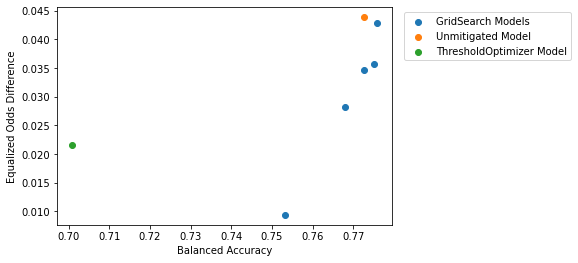

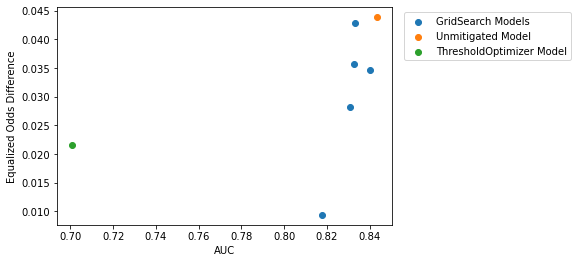

                               Unmitigated ThresholdOptimizer GridSearch_382  \
Overall selection rate            0.763114           0.892259       0.767804   
Demographic parity difference      0.01927           0.013918       0.005981   
Demographic parity ratio          0.975065           0.984523       0.992241   
------                                                                         
Overall balanced error rate       0.772642           0.700864       0.753177   
Balanced error rate difference    0.023887           0.010838       0.008551   
 ------                                                                        
True positive rate                0.887121           0.983619       0.882957   
False positive rate difference    0.043835           0.021563       0.007706   
False negative rate difference    0.003939           0.000114       0.009395   
Equalized odds difference         0.043835           0.021563       0.009395   
  ------                                

In [31]:
get_gridSearch_model(unmitigated_IL_age, postprocess_preds, test_scores, test_preds, models_dict, B_str_test, df_train_balanced_age_IL, Y_train_balanced_age_IL, A_train_balanced_age_IL)
print()
GS_age_IL_models = GS_models
print(GS_age_IL_models)
print()
GS_age_IL_metrics = GS_metrics
print(GS_age_IL_metrics)

In [38]:
# chose the model with AUC = 85.98% from grid search
test_pred_gird_search_382 = GS_age_IL_metrics.get("GridSearch_382")[0]

In [39]:
test_pred_gird_search_382_series = pd.Series(test_pred_gird_search_382)
test_pred_gird_search_382_series.reset_index(drop=True, inplace=True)

In [40]:
test_pred_gird_search_382_series.sum()

25541

In [41]:
B_str_test.reset_index(drop= True, inplace= True)
test_preds

array([1, 0, 1, ..., 1, 1, 1])

In [42]:
migigated_pred_mid_age = pd.concat([test_pred_gird_search_382_series , B_str_test], axis="columns")

In [43]:
test_pred_gird_search_382_series

0        1
1        0
2        1
3        1
4        1
        ..
33260    1
33261    1
33262    1
33263    1
33264    1
Length: 33265, dtype: int32

In [44]:
migigated_pred_mid_age

,0,age
0,1,Non-Middle-Aged
1,0,Middle-Aged
2,1,Middle-Aged
3,1,Middle-Aged
4,1,Non-Middle-Aged
...,...,...
33260,1,Middle-Aged
33261,1,Non-Middle-Aged
33262,1,Non-Middle-Aged
33263,1,Middle-Aged


In [45]:
migigated_pred_mid_age.to_excel(r'il_mitigated_pred_age.xlsx', index=False)

## Conclusion
In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.

# Ethinicity - IL

In [46]:
# load the clean data
d = 'data/Fairlearn_IL_Chicago.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,0,1,0,1,3,2,2,3,2,2,1
1,0,1,1,0,0,1,2,2,2,4,3,4,1
2,0,1,1,1,0,1,1,2,2,3,2,1,1
3,0,1,0,1,0,1,3,2,2,2,2,2,1
4,1,1,1,1,0,1,3,2,2,4,2,3,1


In [47]:
# Extract the sensitive feature - example: ethnicity - hispanic vs non hispanic
C = d["ethnicity"].apply(lambda x:1 if x == 0 else 0)
C_str = C.map({ 1:"Hispanic", 0:"Non-Hispanic"})
C_str

0             Hispanic
1             Hispanic
2             Hispanic
3             Hispanic
4         Non-Hispanic
              ...     
110877        Hispanic
110878        Hispanic
110879        Hispanic
110880        Hispanic
110881        Hispanic
Name: ethnicity, Length: 110882, dtype: object

In [48]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110882 entries, 0 to 110881
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   ethnicity              110882 non-null  int64   
 1   race                   110882 non-null  int64   
 2   gender                 110882 non-null  int64   
 3   action_taken           110882 non-null  int64   
 4   preapproval_requested  110882 non-null  category
 5   loan_type              110882 non-null  category
 6   loan_purpose           110882 non-null  category
 7   interest_only_payment  110882 non-null  category
 8   balloon_payment        110882 non-null  category
 9   debt_to_income_ratio   110882 non-null  category
 10  age                    110882 non-null  int64   
 11  income                 110882 non-null  category
 12  loan_to_value_ratio    110882 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 5.8 MB


In [49]:
df_train, df_test, Y_train, Y_test, C_train, C_test, C_str_train, C_str_test = split(C, C_str)

## Using a Fairness Unaware Model

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')
Test Scores:  [0.95130197 0.57020166 0.82919365 ... 0.91563331 0.87964674 0.91563331]
AUC:  0.8395135473436481


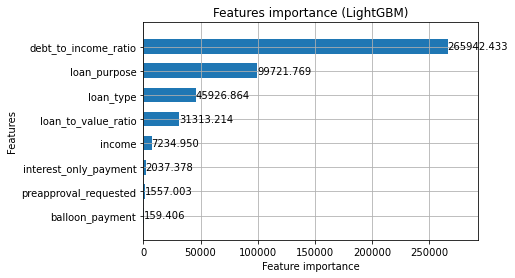

                   FPR       FNR
ethnicity                       
Hispanic      0.340575  0.113719
Non-Hispanic  0.346616  0.108344

                               Unmitigated
Overall selection rate            0.763114
Demographic parity difference     0.030591
Demographic parity ratio          0.960182
------                                    
Overall balanced error rate       0.772642
Balanced error rate difference    0.000333
 ------                                   
True positive rate                0.887121
False positive rate difference    0.006041
False negative rate difference    0.005375
Equalized odds difference         0.006041
  ------                                  
Overall AUC                       0.843145
AUC difference                     0.01253


In [50]:
get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, C_train, C_test, C_str_train, C_str_test)

In [51]:
unmitigated_IL_ethinicity = unmitigated_model
print(unmitigated_IL_ethinicity)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')


In [52]:
il_ethnicity_test_scores = unmitigated_IL_age.predict_proba(df_test)[:, 1]
il_ethnicity_test_preds = (il_ethnicity_test_scores >= np.mean(Y_train)) * 1
il_ethnicity_test_preds = pd.DataFrame(il_ethnicity_test_preds)
C_str_test.reset_index(drop= True, inplace= True)
unmigigated_pred_mid_ethnicity = pd.concat([il_ethnicity_test_preds , C_str_test], axis="columns")
unmigigated_pred_mid_ethnicity

,0,ethnicity
0,1,Hispanic
1,0,Hispanic
2,1,Hispanic
3,1,Hispanic
4,1,Hispanic
...,...,...
33260,1,Hispanic
33261,1,Non-Hispanic
33262,1,Non-Hispanic
33263,1,Hispanic


In [53]:
unmigigated_pred_mid_race.to_excel(r'il_unmitigated_pred_ethnicity.xlsx', index=False)

## Mitigating Equalized Odds Difference with Postprocessing
We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [54]:
df_train_balanced_ethnicity_IL, Y_train_balanced_ethnicity_IL, A_train_balanced_ethinicity_IL = get_thresholdOptimizer_model(unmitigated_IL_ethinicity, test_preds, test_scores, C_train, C_test, C_str_test)
print()
ThresholdOptimizer_IL_ethinicity = TO
print(ThresholdOptimizer_IL_ethinicity)

                               Unmitigated ThresholdOptimizer
Overall selection rate            0.763114           0.885946
Demographic parity difference     0.030591           0.033248
Demographic parity ratio          0.960182           0.962708
------                                                       
Overall balanced error rate       0.772642           0.712349
Balanced error rate difference    0.000333           0.005758
 ------                                                      
True positive rate                0.887121           0.982529
False positive rate difference    0.006041            0.01354
False negative rate difference    0.005375           0.002023
Equalized odds difference         0.006041            0.01354
  ------                                                     
Overall AUC                       0.843145           0.712349
AUC difference                     0.01253           0.005758

ThresholdOptimizer(constraints='equalized_odds',
                   e

The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


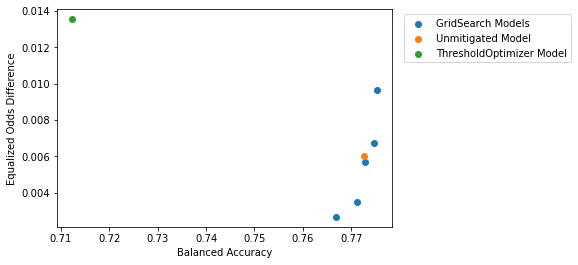

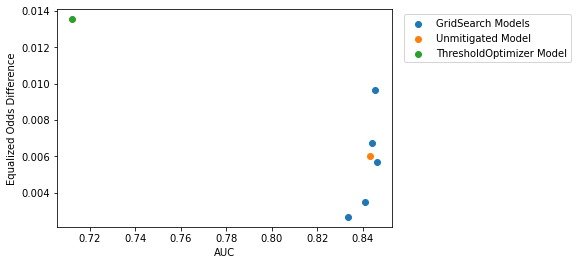

                               Unmitigated ThresholdOptimizer GridSearch_343  \
Overall selection rate            0.763114           0.885946       0.766331   
Demographic parity difference     0.030591           0.033248       0.033384   
Demographic parity ratio          0.960182           0.962708       0.956754   
------                                                                         
Overall balanced error rate       0.772642           0.712349       0.766767   
Balanced error rate difference    0.000333           0.005758       0.001284   
 ------                                                                        
True positive rate                0.887121           0.982529       0.887665   
False positive rate difference    0.006041            0.01354       0.000095   
False negative rate difference    0.005375           0.002023       0.002664   
Equalized odds difference         0.006041            0.01354       0.002664   
  ------                                

In [56]:
get_gridSearch_model(unmitigated_IL_ethinicity, postprocess_preds, test_scores, test_preds, models_dict, C_str_test, df_train_balanced_ethnicity_IL, Y_train_balanced_ethnicity_IL, A_train_balanced_ethinicity_IL)
print()
GS_ethinicity_IL_models = GS_models
print(GS_ethinicity_IL_models)
print()
GS_ethinicity_IL_metrics = GS_metrics
print(GS_ethinicity_IL_metrics)

In [58]:
# chose the model with AUC = 85.98% from grid search
test_pred_gird_search_420 = GS_ethinicity_IL_metrics.get("GridSearch_420")[0]

In [59]:
test_pred_gird_search_420_series = pd.Series(test_pred_gird_search_420)
test_pred_gird_search_420_series.reset_index(drop=True, inplace=True)

In [60]:
test_pred_gird_search_420_series.sum()

25289

In [ ]:
C_str_test.reset_index(drop= True, inplace= True)

In [ ]:
test_preds

In [ ]:
migigated_pred_mid_ethnicity = pd.concat([test_pred_gird_search_420_series , C_str_test], axis="columns")

In [ ]:
test_pred_gird_search_420_series

In [ ]:
migigated_pred_mid_ethnicity

In [ ]:
migigated_pred_mid_ethnicity.to_excel(r'il_mitigated_pred_ethnicity.xlsx', index=False)

## Conclusion
In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.